In [1]:
%run init.ipy

#jax.config.update('jax_platform_name', 'cpu')

from lib import constants
from lib import klatt
from lib import util
import random
from vtr.prior import formant
from lib import timit
from inv import process
from inv import model
from vtr.prior import filter

2023-01-12 14:25:10.250609: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-12 14:25:10.250657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-12 14:25:10.250661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [8]:
def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

NP = 2
Number of data points: 57
Number of model dimensions: 34


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 64,
  'use_oq': True,
  'impose_null_integral': False},
 PoleZeroFilter(3))

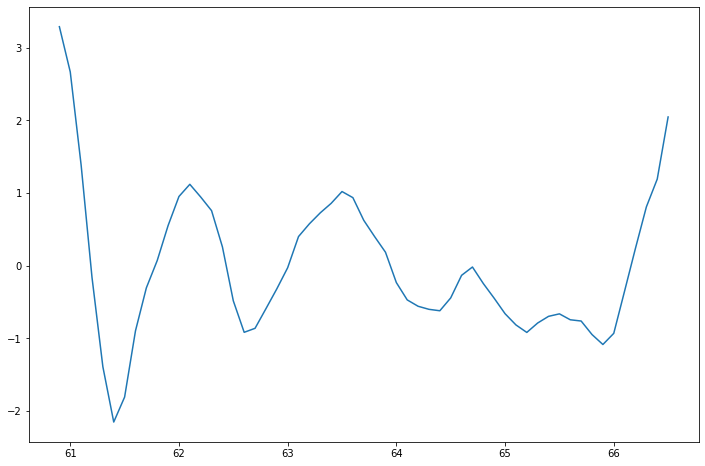

In [9]:
source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 64,
    use_oq = True,
    impose_null_integral = False
)

vtfilter = filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 2, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

## Try VI with jax_advi

Gradients seem to work when `impose_null_integral = False`!!

In general gradients break down close to the bounds of $\theta$.

Out of memory problems can be mitigated by lowering the number of samples used in ADVI ($M$).
The higher $M$, the more stable to optimization, but the longer runtime and memory requirements.

In [10]:
import jax_advi
import jax.scipy

In [11]:
ndim = model.ndim(hyper)
print(ndim)
theta_bijector = model.theta_trajectory_bijector(hyper)

def logabsdet_delw_deltheta(w):
    return -theta_bijector.forward_log_det_jacobian(w)

def loglike(w):
    """Return L(theta(w)) where a priori w ~ N(0, I)"""
    theta = theta_bijector.forward(w)
    logcorrection = logabsdet_delw_deltheta(w)
    loglikelihood = model.full_likelihood(theta, hyper)
    return loglikelihood + logcorrection

def logprior(w):
    return jnp.sum(jax.scipy.stats.norm.logpdf(w))

def minus_inf_if_nan(x):
    return jax.lax.cond(jnp.isnan(x), lambda: -jnp.inf, lambda: x)

def logjoint(w):
    lj = loglike(w) + logprior(w)
    return minus_inf_if_nan(lj)

# Test our likelihood and joint functions: OK
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())

l1 = model.full_likelihood(theta, hyper) + prior.log_prob(theta)

#
w = theta_bijector.inverse(theta)
l2 = logjoint(w)

#
l1, l2

34
[Memory]172.2s, 2.9min  : Loading posterior_of_fitted_lf_values...
[Memory]172.2s, 2.9min  : Loading run_nested...
[Memory]172.3s, 2.9min  : Loading posterior_of_fitted_TFB_values...
[Memory]172.3s, 2.9min  : Loading run_nested...
[Memory]172.4s, 2.9min  : Loading posterior_of_fitted_lf_values...
[Memory]172.4s, 2.9min  : Loading run_nested...
[Memory]172.4s, 2.9min  : Loading posterior_of_fitted_TFB_values...
[Memory]172.4s, 2.9min  : Loading run_nested...


(DeviceArray(-3105.72387817, dtype=float64),
 DeviceArray(-3105.72387817, dtype=float64))

In [12]:
import jax_advi.advi

theta_shapes = {'w': (ndim,)}

# Jitting happens inside
result = jax_advi.advi.optimize_advi_mean_field(
    theta_shapes,
    lambda theta: logprior(theta['w']),
    lambda theta: loglike(theta['w']),
    verbose=True,
    M=25,
    #opt_method="L-BFGS-B" # This is faster and seems to be leap succesfully over early local minima
)

'f': 3385.808776040351, ||grad(f)||: 9555.735828595558
'f': 1873.8864989996093, ||grad(f)||: 4325.475529492689
'f': 1019.3744185501115, ||grad(f)||: 1613.9185289242434
'f': 516.4679313082389, ||grad(f)||: 648.6173797330616
'f': 280.71638775075786, ||grad(f)||: 239.91943761628633
'f': 194.8002631564855, ||grad(f)||: 89.25321152461393
'f': 164.49728449665554, ||grad(f)||: 30.611355621699907
'f': 147.17973389574468, ||grad(f)||: 13.237126129428828
'f': 148.89584847937928, ||grad(f)||: 126.66170622949686
'f': 141.60595331034335, ||grad(f)||: 15.731135070844115
'f': 132.67129396215984, ||grad(f)||: 15.828135359182475
'f': 128.30227297126504, ||grad(f)||: 22.795450005087815
'f': 123.80291453648483, ||grad(f)||: 16.407113725219865
'f': 117.39603333268944, ||grad(f)||: 12.585872291288531
'f': 110.52724940107991, ||grad(f)||: 32.782088303409644
'f': 105.27372853097575, ||grad(f)||: 17.282267417193854
'f': 106.14012059073795, ||grad(f)||: 42.43893450357961
'f': 102.66900803906509, ||grad(f)||: 1

0	log L = 3.826757508085592	SNR [dB] = 27.321213784087245
1	log L = -0.9316932004668104	SNR [dB] = 28.56425265645396
2	log L = -26.59423332617041	SNR [dB] = 28.01485294672968


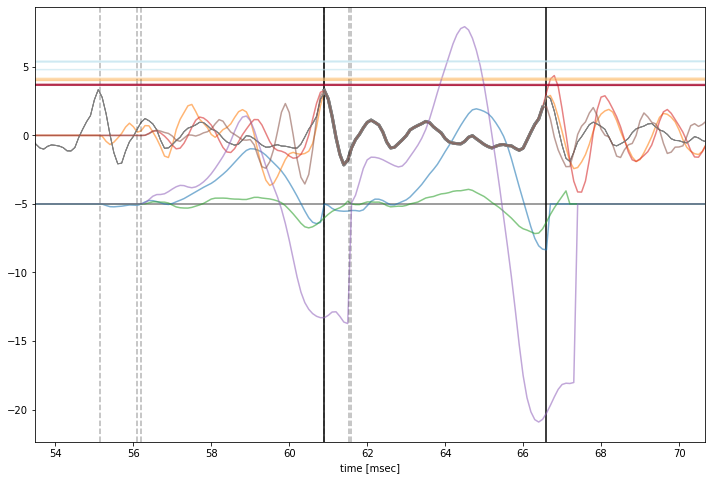

In [13]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

nsamp = 3

w_samples = result['draws']['w'][:nsamp,:]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

In [49]:
theta

{'noise_sigma': DeviceArray(0.22270392, dtype=float64),
 'delta': DeviceArray(-0.42545211, dtype=float64),
 'source': DeviceArray([[ 2.13555697,  0.10494497, 10.05083093,  0.96300677],
              [ 2.04506109,  0.09503027, 10.83707027,  0.96079874]],            dtype=float64),
 'filter': DeviceArray([[ 577.92718361, 1772.27252806, 2580.5762391 ,   26.8535595 ,
                 25.80332801,   20.31625319],
              [ 569.26119419, 1794.00194505, 2604.09129122,   27.0826757 ,
                 26.00990782,   20.34730955]], dtype=float64),
 'g': DeviceArray([[ 2.53281638, -1.2816139 , -0.33703964, -0.74402894,
                1.0366102 ,  0.95083271],
              [-0.43580991, -0.26611904,  0.9479996 , -1.465394  ,
                0.58565851,  1.90664774]], dtype=float64)}

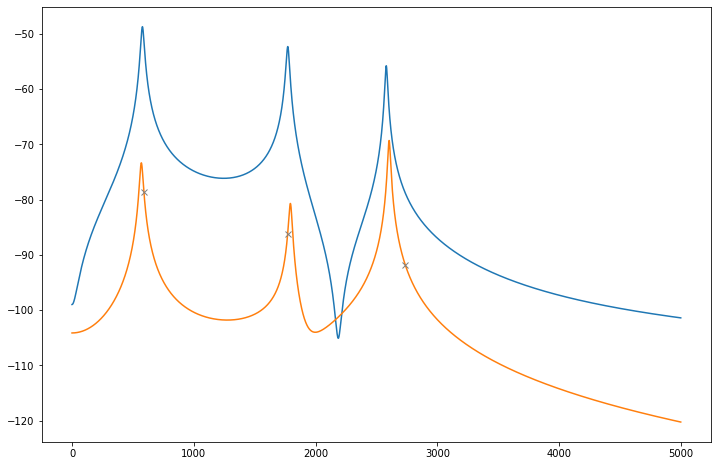

In [50]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

## Higher $K$